<a href="https://colab.research.google.com/github/JackGraymer/Advanced-GenAI/blob/main/2.2_response_synthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Generative Artificial Intelligence
**Project - Designing a RAG-Based Q&A System for News Retrieval**

**Authors:** Vsevolod Mironov, Pascal Küng, Alvaro Cervan (Group 5)


# Step 2.2 Aggregation and Response Synthesis (Post-Retrieval) -<br> Merging retrieved results and applying advanced post-retrieval techniques

**Contribution:** Vsevolod Mironov, Pascal Küng, Alvaro Cervan

**Goal of this step:** This step deals with post-retrieval processing. After an initial set of candidate chunks is retrieved, techniques are applied to refine these results before they are passed to the LLM. The primary focus is on re-ranking, using sophisticated models to reorder the retrieved chunks based on relevance. Other techniques like generating summaries or fusing information from multiple chunks are also explored.

# 1.0 Loading Data and functions from previous stage

## 1.1 Setup of the environment

### Installations and loading of packages

In [ ]:
!pip install torch torchvision torchaudio

In [2]:
import torch
if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
    # The model will automatically be placed on the GPU
else:
    print("GPU is not available. Running on CPU.")

GPU is available: Tesla T4


In [ ]:
!pip install langchain langchain_groq faiss_cpu

Below the necessary libraries are installed and loaded into the environment.

In [3]:
import os
import re
import json
import asyncio
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import pickle
import faiss
from sentence_transformers import SentenceTransformer, util

In [4]:
# Allows asyncio to run in a notebook environment
import nest_asyncio
nest_asyncio.apply()

from typing import List, Literal
from pydantic import BaseModel, Field
from openai import OpenAI

### Setting seeds and mounting Google Drive storage folder

In [5]:
# Set the seed for consistent results
seed_value = 2138247234
random.seed(seed_value)
np.random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

Below we mount a shared Google Drive folder as a data storage and define the base path of the folder that will be used in the runtime.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
base_folder = '/content/drive/MyDrive/AdvGenAI'

### Check properties of environment

In [8]:
!nvidia-smi

Thu Jun  5 15:53:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [9]:
!pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.7.0
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.1
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.9.0
argon2-cffi                           23.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.2
arviz                                 0.21.0
astropy                               7.1.0
astropy-iers-data                     0.2025.5.26.0.

## 1.2 Loading the datasets

In [10]:
df = pd.read_csv(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-02-chunked-dataset.csv'))

In [11]:
# Load Q_A_data file
with open(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-08-q-a-file-with-relevancy.pkl'), 'rb') as f:
    Q_A_ground_thruth_relevancy_dict = pickle.load(f)

## 1.3 Build Dense Vector Store and define Retrievers

In [12]:
# Build FAISS Index for Multilingual Dense Retrieval
# Uses Sentence-BERT (distiluse-base-multilingual-cased-v1) for multilingual embeddings (English & German supported)
def build_faiss_index(df, model_name='sentence-transformers/distiluse-base-multilingual-cased-v1'):
    model = SentenceTransformer(model_name)
    # Convert all chunk texts to embeddings (normalized for cosine similarity)
    embeddings = model.encode(df['chunk_text'].tolist(), convert_to_numpy=True, normalize_embeddings=True)
    dim = embeddings.shape[1]
    index = faiss.IndexFlatIP(dim)  # Inner product on normalized vectors = cosine similarity
    index.add(embeddings)
    return model, index, embeddings, df.reset_index(drop=True)

In [13]:
# Multilingual Semantic Retrieval (English or German query)
def retrieve_dense_faiss(query, model, index, df, top_k=5):
    # Query can be in English or German (model is multilingual)
    query_vec = model.encode([query], convert_to_numpy=True, normalize_embeddings=True)
    scores, indices = index.search(query_vec, top_k)
    results = df.iloc[indices[0]].copy()
    results['score'] = scores[0]
    return results[['unique_chunk_id', 'chunk_text', 'score', 'title']]

# Build FAISS index only once (if not already built)
dense_model, faiss_index, dense_embeddings, dense_df = build_faiss_index(df)

modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.24k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

In [ ]:
test_query = "Who is the rector of ETH"
print("Query:", test_query)
dense_results = retrieve_dense_faiss(test_query, dense_model, faiss_index, dense_df)
display(dense_results)

Query: Who is the rector of ETH


,unique_chunk_id,chunk_text,score,title
15758,2547_00,ETH is one of the world’s leading technical un...,0.494083,Where next for eth
10407,1289_01,Was macht der Direktor des ETH-Zentrums Singap...,0.477289,Wer in singapur forschen will soll sich jetzt ...
15177,2345_02,What does this mean for members of ETH who app...,0.474332,Ombudspersons trio is complete
12798,1917_06,## Wie die ETH zu ihrer Rektorin oder ihrem Re...,0.468042,Guenther dissertori als rektor eth zuerich
19189,3205_02,How relevant is it whether ETH acts as the ove...,0.462756,Roland siegwart why the nccrs are so important...


In [14]:
# Define OpenAI Api Key
import openai
from google.colab import userdata

api_key = userdata.get('openai_advAI')

In [15]:
# Pydantic Model for LLM Output
class GeneratedHydeDocuments(BaseModel):
    documents: List[str] = Field(
        description="A list of three diverse, concise, and relevant hypothetical documents that comprehensively answer the original query.",
        min_length=3,
        max_length=3
    )

In [16]:
# OpenAI Function for Generating Variations
# Note: You'll need to have the OpenAI API key set as an environment variable OPENAI_API_KEY
# or pass it to the OpenAI client.

def get_openai_client(api_key: str = None):
    """Initializes and returns an OpenAI client."""
    return OpenAI(api_key=api_key)

def generate_variations_openai(
    original_query: str,
    variation_type: Literal["queries", "hyde_documents"],
    num_variations: int = 3,
    llm_model: str = "gpt-4o",
    client: OpenAI = None,
    api_key: str = None
) -> List[str]:
    """
    Generates multiple query variations or hypothetical documents using OpenAI LLM.
    """
    if client is None:
        client = get_openai_client(api_key=api_key) # Use passed api_key

    if num_variations != 3:
        # This warning is good, Pydantic models enforce 3.
        print(f"Warning: Pydantic models are set for 3 variations. Generating {num_variations} might conflict if not 3.")
    json_structure_example_hyde = f"""
Your response MUST be a JSON object with a single key "documents".
The value of "documents" MUST be a list of exactly {num_variations} strings, where each string is a hypothetical document.
Example for {num_variations} variations:
{{
  "documents": [
    "hypothetical document text 1...",
    "hypothetical document text 2...",
    "hypothetical document text 3..."
  ]
}}
"""
    if variation_type == "hyde_documents":
        type_desc = "hypothetical documents. Each document should be a concise, ideal answer to the original query, rich in relevant keywords and concepts, and diverse from the others."
        json_structure_guidance = json_structure_example_hyde
    else:
        raise ValueError("variation_type must be 'queries' or 'hyde_documents'")

    system_prompt_template = """
You are an expert in search query optimization and information retrieval.
Your primary task is to generate exactly {num_variations} diverse and effective {type_description} based on the original user query.
These variations are crucial for retrieving the most relevant documents from a corpus.

{json_guidance}

Ensure your output strictly adheres to this JSON structure. Do not include any other text, explanations, or apologies.
"""
    system_prompt = system_prompt_template.format(
        num_variations=num_variations,
        type_description=type_desc,
        json_guidance=json_structure_guidance
    )
    user_prompt = f"Original Query: '{original_query}'"

    try:
        response = client.chat.completions.create(
            model=llm_model,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            response_format={"type": "json_object"},
            temperature=0.6,
        )

        json_response_str = response.choices[0].message.content

        parsed_output = GeneratedHydeDocuments.model_validate_json(json_response_str)
        return parsed_output.documents

    except Exception as e:
        print(f"Error calling OpenAI or parsing response: {e}")
        # Fallback to simple placeholder variations in case of API error
        # Using a more distinct fallback to differentiate from potential successful but simple LLM output
        error_prefix = "ERROR_FALLBACK_"
        return [f"{error_prefix}Hypothetical document for {original_query} - version {i+1}. This document details..." for i in range(num_variations)]

In [ ]:
test_query = "Is ETH developing an AI system to develop treatments in the field of medicine?"
print("Query:", test_query)
print("HyDE Documents:")
pprint.pprint(generate_variations_openai(test_query, variation_type="hyde_documents", api_key=api_key))

Query: Is ETH developing an AI system to develop treatments in the field of medicine?
HyDE Documents:
['ETH Zurich is at the forefront of integrating artificial intelligence in the '
 "medical field. The university's Department of Computer Science is actively "
 'developing AI systems aimed at revolutionizing treatment methodologies. '
 'These systems leverage machine learning algorithms to analyze vast datasets, '
 'potentially leading to breakthroughs in personalized medicine and drug '
 "discovery. ETH's efforts are part of a broader initiative to enhance "
 'healthcare outcomes through technological innovation.',
 'While ETH Zurich is renowned for its cutting-edge research in both '
 'artificial intelligence and medicine, it does not currently have a dedicated '
 'AI system specifically for developing medical treatments. However, '
 'researchers at ETH are involved in various interdisciplinary projects that '
 'utilize AI to improve diagnostic tools and optimize treatment plans, '


In [23]:
def min_max_normalize(scores_series):
    min_score = scores_series.min()
    max_score = scores_series.max()

    if max_score == min_score:
        return pd.Series([0.0 if min_score == 0 else 1.0] * len(scores_series),
                         index=scores_series.index, dtype=float)

    normalized_scores = (scores_series - min_score) / (max_score - min_score)
    return normalized_scores

def normalize_scores(df_results, score_column='score'):
    """
    Normalizes scores in a DataFrame column to a 0-1 range.
    Uses the min_max_normalize function.
    """
    df_results[score_column] = min_max_normalize(df_results[score_column])
    return df_results

In [25]:
def retrieve_dense_faiss_hyde_multi(query, model, dense_embeddings, dense_df, top_k=5):
    if dense_embeddings is None or dense_df.empty:
        return pd.DataFrame(columns=['unique_chunk_id', 'chunk_text', 'score', 'title'])

    hyde_documents = generate_variations_openai(query, variation_type="hyde_documents",
                                                api_key=api_key, num_variations=3)
    total_scores = np.zeros(len(dense_df))

    for hyde_doc_text in hyde_documents:
        hyde_vec = model.encode([hyde_doc_text], convert_to_numpy=True, normalize_embeddings=True)
        current_scores = (hyde_vec @ dense_embeddings.T).flatten()
        total_scores += current_scores

    num_docs = len(hyde_documents)
    avg_scores_values = total_scores / num_docs
    avg_scores = pd.Series(avg_scores_values, index=dense_df.index)

    normalized_scores = min_max_normalize(avg_scores)

    results_df = dense_df.copy()
    results_df['score'] = normalized_scores

    top_results = results_df.sort_values('score', ascending=False).head(top_k)
    return top_results[['unique_chunk_id', 'chunk_text', 'score', 'title']]

In [27]:
def retrieve_hybrid_standard_dense_plus_dense_hyde(
    query: str,
    # Shared Dense components
    dense_model,         # SentenceTransformer model
    dense_df: pd.DataFrame, # DataFrame of documents for dense retrieval
    # Standard Dense specific
    faiss_index,         # FAISS index for standard dense search
    # Dense HyDE specific
    dense_embeddings,    # Numpy array of pre-computed document embeddings for HyDE part
    # Retrieval parameters
    top_k: int = 5,      # Final number of chunks to return
    weight_standard_dense: float = 0.3,
    weight_dense_hyde: float = 0.7
):
    """
    Retrieves and combines documents using Standard Dense and Dense HyDE retrieval.

    Args:
        query (str): The search query.
        dense_model: The SentenceTransformer model (used by both retrievers).
        dense_df: DataFrame of documents (used by both retrievers).
        faiss_index: FAISS index for standard dense retrieval.
        dense_embeddings: Numpy array of pre-computed document embeddings for Dense HyDE.
        top_k (int): The final number of documents to return.
        weight_standard_dense (float): Weight for the standard dense scores.
        weight_dense_hyde (float): Weight for the Dense HyDE scores.

    Returns:
        pd.DataFrame: DataFrame of the top_k retrieved documents with their combined scores.
    """
    intermediate_top_k = max(20, 4 * top_k)

    # 1. Retrieve with Standard Dense Search
    std_dense_results_raw = retrieve_dense_faiss(
        query, dense_model, faiss_index, dense_df, top_k=intermediate_top_k)

    std_dense_results_normalized = normalize_scores(std_dense_results_raw.copy(), score_column='score')
    std_dense_results_normalized['score'] *= weight_standard_dense
    std_dense_results_final = std_dense_results_normalized[['unique_chunk_id', 'chunk_text', 'title', 'score']].set_index('unique_chunk_id')

    # 2. Retrieve with Dense HyDE
    dense_hyde_results_raw = retrieve_dense_faiss_hyde_multi(
        query, dense_model, dense_embeddings, dense_df, top_k=intermediate_top_k)

    dense_hyde_results_normalized = normalize_scores(dense_hyde_results_raw.copy(), score_column='score')
    dense_hyde_results_normalized['score'] *= weight_dense_hyde
    dense_hyde_results_final = dense_hyde_results_normalized[['unique_chunk_id', 'chunk_text', 'title', 'score']].set_index('unique_chunk_id')

    # 3. Combine results
    combined_df = pd.concat(
        [std_dense_results_final.add_suffix('_std_dense'), dense_hyde_results_final.add_suffix('_dense_hyde')],
        axis=1,
        join='outer'
    )

    combined_df['score_std_dense'] = combined_df['score_std_dense'].fillna(0)
    combined_df['score_dense_hyde'] = combined_df['score_dense_hyde'].fillna(0)
    combined_df['final_score'] = combined_df['score_std_dense'] + combined_df['score_dense_hyde']
    combined_df['chunk_text'] = combined_df['chunk_text_std_dense'].combine_first(combined_df['chunk_text_dense_hyde'])
    combined_df['title'] = combined_df['title_std_dense'].combine_first(combined_df['title_dense_hyde'])

    combined_df = combined_df.reset_index().rename(columns={'index': 'unique_chunk_id'})

    # 4. Sort by the new combined score and take the final top_k
    final_results = combined_df.sort_values(by="final_score", ascending=False).head(top_k)

    # Ensure all required columns are present in the final output
    required_cols = ['unique_chunk_id', 'chunk_text', 'title', 'score']
    output_df = pd.DataFrame(columns=required_cols) # Initialize with correct columns
    for col in required_cols:
        if col == 'score':
            # Ensure final_score is present or default to an empty float Series
            output_df[col] = final_results.get('final_score', pd.Series(dtype=float if final_results.empty else final_results['final_score'].dtype))
        else:
            # Ensure other columns are present or default to an empty object Series
             output_df[col] = final_results.get(col, pd.Series(dtype=object if final_results.empty else final_results.get(col, pd.Series(dtype=object)).dtype))

    output_df['chunk_text'] = output_df['chunk_text'].fillna("N/A")
    output_df['title'] = output_df['title'].fillna("N/A")
    output_df['score'] = output_df['score'].fillna(0.0)


    return output_df[['unique_chunk_id', 'chunk_text', 'title', 'score']]

In [28]:
model_name = "sentence-transformers/distiluse-base-multilingual-cased-v1"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dense_model = SentenceTransformer(model_name, device=device)

In [29]:
# The query you want to use for the hybrid search
query = "Is ETH developing an AI system to develop treatments in the field of medicine?"

print(f"Performing hybrid search (Standard Dense + Dense HyDE) for query: '{query}'")

hybrid_results_dense_plus_hyde = retrieve_hybrid_standard_dense_plus_dense_hyde(
    query=query,
    # Shared Dense components
    dense_model=dense_model,
    dense_df=dense_df,
    # Standard Dense specific
    faiss_index=faiss_index,
    # Dense HyDE specific
    dense_embeddings=dense_embeddings,
    # Retrieval parameters
    top_k=5,
)

print("\nHybrid Retrieval Results (Standard Dense + Dense HyDE):")
display(hybrid_results_dense_plus_hyde)

Performing hybrid search (Standard Dense + Dense HyDE) for query: 'Is ETH developing an AI system to develop treatments in the field of medicine?'

Hybrid Retrieval Results (Standard Dense + Dense HyDE):


,unique_chunk_id,chunk_text,title,score
18,4220_08,## “Artificial intelligence for Switzerland” s...,New app unmasks forged documents,0.713245
0,4157_01,- They advise companies to develop an AI strat...,Ai reality lags the hype in swiss tech industries,0.710136
20,4194_06,## “Artificial Intelligence for Switzerland” s...,Ai designs new drugs based on protein structures,0.607325
22,4223_11,## “Artificial intelligence for Switzerland” s...,Climate friendly renovations using straw and hemp,0.586364
21,4157_13,## “Artificial intelligence for Switzerland” s...,Ai reality lags the hype in swiss tech industries,0.586364


## 1.4 Prepare retrieved chunks for the different questions

To have comparable results we prepare the retrieved chunks for the questions from the Q-A dataset.

We will store the string of the questions as the keys and the returned dataframes from the retrieval as the corresponding values. With this setup we can utilize the query string in a function input and access the retrieved chunks (arranged in a dataframe) by selecting from the dictionary.

We return the 100 most relevant chunks in this initial retrieval.

In [40]:
precalc_retrieved_chunks = dict()

In [42]:
for q_id, data in Q_A_ground_thruth_relevancy_dict.items():
    query = data["question"]

    print(f"\nQ{q_id}: {query[:80]}{'...' if len(query) > 80 else ''}")

    retrieved_df = retrieve_hybrid_standard_dense_plus_dense_hyde(query = query,
                                                                  dense_model = dense_model,
                                                                  dense_df = dense_df,
                                                                  faiss_index = faiss_index,
                                                                  dense_embeddings = dense_embeddings,
                                                                  top_k = 100,
                                                                  weight_standard_dense = 0.3,
                                                                  weight_dense_hyde = 0.7)
    retrieved_df.reset_index(drop=True, inplace=True)
    display(retrieved_df.head(2))
    precalc_retrieved_chunks[query] = retrieved_df.copy()


Q1: Who was president of ETH in 2003?


,unique_chunk_id,chunk_text,title,score
0,3947_09,While ETH Zurich has always had an open and in...,A grounded globetrotter,0.861710
1,2867_01,The importance of sustainability for ETH Zuric...,Eth sustainability to be realigned,0.541304



Q2: Who were the rectors of ETH between 2017 and 2022?


,unique_chunk_id,chunk_text,title,score
0,0269_00,Sarah Springman war 18 Jahre Professorin für G...,Die rektorin der herzen wird emeritiert globe,0.703867
1,0286_02,Ein wichtiges Anliegen war der Rektorin auch d...,Ein ausblick und ein emotionales goodbye,0.574548



Q3: Who at ETH received ERC grants?


,unique_chunk_id,chunk_text,title,score
0,4007_07,## Benchmark for top researchers: ERC Grants\n...,Two advanced grants for eth,0.937181
1,3509_01,## Building on past success\nETH Zurich is one...,Seven eth researchers awarded grants,0.845957



Q4: When did the InSight get to Mars?


,unique_chunk_id,chunk_text,title,score
0,1190_08,## Die NASA Mars-Mission InSight\nInSight (Int...,Raetsel um kern des mars geloest,0.951196
1,3913_02,"## Measurements on Mars\nOn 26 November 2018, ...",Other worlds,0.899499



Q5: What did Prof. Schubert say about ﬂying?


,unique_chunk_id,chunk_text,title,score
0,4169_06,## Leveraging the professorship\nOne year late...,Innovative materials and remarkable people,0.766987
1,4169_05,## Aircraft developer and consultant\nThanks t...,Innovative materials and remarkable people,0.701058



Q6: What is e-Sling?


,unique_chunk_id,chunk_text,title,score
0,3826_07,## Further informationen\n1 ETH Zurich’s air t...,Carbon tax to finance teaching project,0.700000
1,4155_08,To investigate what this will mean for the cou...,Globe eth research supply support to the swiss...,0.696151



Q7: Who are famous ETH alumni?


,unique_chunk_id,chunk_text,title,score
0,3166_08,ETH Zurich is one of the leading international...,50 million swiss francs for institute of theor...,0.832589
1,0132_10,L'ETH Zurich est lune des premières universi...,50 millions de francs pour l institut d etudes...,0.705984



Q8: Who at ETH currently works on research regarding climate change?


,unique_chunk_id,chunk_text,title,score
0,3332_05,## Important drivers of changed ecosystems\nFo...,How climate change is disrupting ecosystems,0.742502
1,3641_07,## About Jan Carmeliet\nJan Carmeliet (56) is ...,Asphalt has a major downside,0.700000



Q9: How do alpine plants respond to climate change?


,unique_chunk_id,chunk_text,title,score
0,1130_03,## Grösser und schneller\nDas könnte dazu führ...,Globe was pflanzen in den bergen blueht,0.968983
1,3395_00,Climate change isn’t just about glaciers melti...,The climate risk of insect pests,0.919612



Q10: How would you make fertilizer without carbon emissions?


,unique_chunk_id,chunk_text,title,score
0,3691_04,Producing enough biofuels to phase out gasolin...,Elektroautos,0.929525
1,0559_04,Zu den Biotreibstoffen: Sie ausreichend zu pro...,Elektroautos,0.928516



Q11: What research is ETH famous for?


,unique_chunk_id,chunk_text,title,score
0,3166_08,ETH Zurich is one of the leading international...,50 million swiss francs for institute of theor...,0.816201
1,0132_10,L'ETH Zurich est lune des premières universi...,50 millions de francs pour l institut d etudes...,0.714837



Q12: How much of ETH’s electricity consumption is due to computing? How did that deve...


,unique_chunk_id,chunk_text,title,score
0,2988_02,## High electricity costs expected until at le...,Die eth zuerich setzt sich fuer 2023 ein energ...,0.950627
1,2988_05,Since ETH has already bought 67 percent of its...,Die eth zuerich setzt sich fuer 2023 ein energ...,0.905571



Q13: What are pseudocereals and who does research on them?


,unique_chunk_id,chunk_text,title,score
0,3575_03,## A plea for pseudocereals\nThe three most im...,More variety eat buckwheat,0.70000
1,0594_03,"Das sind Pflanzen, die wir wie Getreide anbaue...",Mehr vielfalt esst buchweizen,0.68126



Q14: Who is working on methods for targeted cancer treatment, and what do they use?


,unique_chunk_id,chunk_text,title,score
0,3952_00,Researchers from the University Hospitals in Z...,Detailed tumour profiling,0.954357
1,4290_02,## Drugs that target cancer more effectively\n...,Protein scissors for more effective cancer tre...,0.886572



Q15: How is ETH research investigating methods to avoid diarrhea?


,unique_chunk_id,chunk_text,title,score
0,0488_07,Bei der Produktentwicklung und dem Ermitteln v...,Pharmabiome,0.852292
1,4086_00,## In brief\n- ETH Zurich researchers have dev...,Treating bladder infections with viruses,0.760208



Q16: What is ETH Plus?


,unique_chunk_id,chunk_text,title,score
0,2291_00,ETH is the size of a small city. It comprises ...,Neues onlineangebot zur meldung von schaeden u...,0.984287
1,3649_05,ETH wants to position itself as a leading cent...,Data science interview lothar thiele,0.942685



Q17: How do birds learn new songs?


,unique_chunk_id,chunk_text,title,score
0,4243_07,"## Learning from bird songs\nHowever, the algo...",Ai listens to the sound of healthy machines,1.000000
1,1061_08,## Lernen von Vogelstimmen\nDer Algorithmus lä...,Kuenstliche intelligenz versteht den klang ges...,0.807039



Q18: What connections does ETH have to Hong Kong?


,unique_chunk_id,chunk_text,title,score
0,3166_08,ETH Zurich is one of the leading international...,50 million swiss francs for institute of theor...,0.704107
1,3166_09,"The ETH Zurich Foundation unites companies, pr...",50 million swiss francs for institute of theor...,0.642989



Q19: For how many years has ETH done research on Quantum Computing?


,unique_chunk_id,chunk_text,title,score
0,0304_00,Derzeit intensivieren Unternehmen und Forschun...,Master quantum engineering,0.886627
1,3997_10,. ETH also joined forces with PSI to back the ...,Interview wallraff wood,0.770980



Q20: What are the current projections for the student numbers at ETH?


,unique_chunk_id,chunk_text,title,score
0,1319_03,## Bundesbeitrag hält nicht mit Studierendenza...,Medienmitteilung finanzielle unsicherheiten ge...,0.833105
1,1885_00,Die ETH Zürich hat eine starke Wachstumsphase ...,Eth zuerich verzichtet auf neugestaltung der p...,0.811549



Q21: Why should I study at ETH?


,unique_chunk_id,chunk_text,title,score
0,3166_08,ETH Zurich is one of the leading international...,50 million swiss francs for institute of theor...,0.758776
1,3095_00,ETH Zurich is known for top-level research and...,Top speed knowledge transfer,0.669546



Q22: Who investigated the catastrophic events in Tibet in 2016, and what was found?


,unique_chunk_id,chunk_text,title,score
0,3338_00,"The earthquake, which occurred on 15 November ...",Anthropogenic or not,0.963723
1,0091_02,Trotz intensiver Forschung können Wissenschaft...,Erc synergy grants,0.818104



Q23: Why should ETH receive any additional funding?


,unique_chunk_id,chunk_text,title,score
0,3649_05,ETH wants to position itself as a leading cent...,Data science interview lothar thiele,0.877398
1,2023_13,- Nutzung neuer Technologien\n Neue Entwicklun...,Rethink digitalisierungsstrategie der verwaltung,0.719170



Q24: Anybody at ETH doing anything for people with disabilities?


,unique_chunk_id,chunk_text,title,score
0,2997_04,## Barrier-free at ETH Zurich\nETH Zurich is c...,Barrier free eth a change of perspective,0.817506
1,3868_04,That’s what we do in the CYBATHLON @school pro...,Blog riener inclusion how technology brings pe...,0.731593



Q25: Does ETH organize any competitions?


,unique_chunk_id,chunk_text,title,score
0,1692_00,Die Teilnehmerinnen verbringen drei Tage an de...,Anmeldung fuers informatik schnupperstudium je...,0.751470
1,3166_08,ETH Zurich is one of the leading international...,50 million swiss francs for institute of theor...,0.686602


In [43]:
# Save dictionary of precalculated retrieved chunks
filename = os.path.join(base_folder, "Stage3/Working-dir/Stage3-01-precalc-retrieved-chunks.pkl")
with open(filename, 'wb') as f:
    pickle.dump(precalc_retrieved_chunks, f)

print(f"Dictionary saved to {filename}")

Dictionary saved to /content/drive/MyDrive/AdvGenAI/Stage3/Working-dir/Stage3-01-precalc-retrieved-chunks.pkl


## 1.5 Load data and functions for evaluation

In [ ]:
# Load dictionary of precalculated retrieved chunks
filename = os.path.join(base_folder, "Stage3/Working-dir/Stage3-01-precalc-retrieved-chunks.pkl")
with open(filename, 'rb') as f:
    precalc_retrieved_chunks = pickle.load(f)
print(f"Dictionary loaded from {filename}:")

In [ ]:
df = pd.read_csv(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-02-chunked-dataset.csv'))

In [ ]:
# Load Q_A_data file
with open(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-08-q-a-file-with-relevancy.pkl'), 'rb') as f:
    Q_A_ground_thruth_relevancy_dict = pickle.load(f)

In [35]:
# show the first question with filtered ground truth relevance (>0)
for q_id in list(Q_A_ground_thruth_relevancy_dict.keys())[:1]:
	print(f"Q{q_id}: {Q_A_ground_thruth_relevancy_dict[q_id]['question']}")
	# Filter ground truth relevance to only those with score > 0
	filtered_relevance = {cid: score for cid, score in Q_A_ground_thruth_relevancy_dict[q_id]["ground_truth_relevance"].items() if score > 0}
	print("Ground truth relevance (>0):", filtered_relevance)

Q1: Who was president of ETH in 2003?
Ground truth relevance (>0): {'4042_15': 0.5, '2259_09': 0.5, '3766_04': 0.5, '3896_00': 0.5, '3968_08': 0.5, '2878_04': 0.5, '3121_01': 0.5, '3481_01': 0.5, '3795_07': 0.5, '1239_13': 0.5, '3429_05': 0.5, '3590_00': 0.5, '2603_02': 0.5, '4183_00': 0.5, '3980_00': 0.5, '3935_04': 0.5, '3805_01': 0.5, '4311_02': 0.5, '3175_04': 0.5, '3804_04': 0.5, '0857_03': 0.5, '3710_01': 0.5, '3510_00': 0.5, '3707_02': 0.5, '2630_02': 0.5, '3127_01': 0.5, '3166_01': 0.5, '3363_02': 0.5, '3795_08': 1.0, '2358_00': 0.5, '3433_00': 0.5, '3947_08': 0.5, '4166_23': 0.5, '2641_00': 0.5, '0241_17': 0.5, '3762_09': 0.5, '3804_01': 0.5, '3429_06': 0.5, '4135_01': 0.5, '4183_04': 0.5, '2814_05': 0.5, '4105_13': 0.5, '3021_09': 0.5, '3466_05': 0.5}


**Precision@k (Graded)**: This will be the sum of the relevance scores of the retrieved items in the top k positions, divided by k.

**Recall@k (Graded)**: This will be the sum of the relevance scores of the retrieved items in the top k positions, divided by the total sum of relevance scores for that question in the ground truth.

**MRR (Graded & Cumulative)**: We'll iterate through the retrieved items, summing their relevance scores. The reciprocal rank will be calculated at the first position where this cumulative sum is >= 1.0. If the sum never reaches 1.0, the MRR is 0.

In [36]:
def precision_at_k(retrieved_ids, ground_truth_scores_dict, k):
    retrieved_k = retrieved_ids[:k]
    achieved_score_at_k = sum(ground_truth_scores_dict.get(cid, 0.0) for cid in retrieved_k)
    return achieved_score_at_k / k

def recall_at_k(retrieved_ids, ground_truth_scores_dict, k):
    retrieved_k = retrieved_ids[:k]
    achieved_score_at_k = sum(ground_truth_scores_dict.get(cid, 0.0) for cid in retrieved_k)

    total_possible_score = sum(score for score in ground_truth_scores_dict.values() if score > 0)

    if total_possible_score == 0:
        # If there are no relevant items in the ground truth,
        return 0.0
    return achieved_score_at_k / total_possible_score

def mrr_graded_cumulative(retrieved_ids, ground_truth_scores_dict):
    current_score_sum = 0.0
    for rank, cid in enumerate(retrieved_ids, start=1):
        score = ground_truth_scores_dict.get(cid, 0.0)
        if score > 0:  # Only consider items with positive relevance
            current_score_sum += score
            if current_score_sum >= 1.0:
                return 1 / rank
    return 0.0

In [37]:
#  Plotting Function
def plot_evaluation_results_extended(results_dict, title="Retrieval Evaluation Metrics Comparison"):
    data = []
    for model_name, metrics in results_dict.items():
        for metric_name, value in metrics.items():
            data.append({
                "Model": model_name,
                "Metric": metric_name,
                "Score": value
            })

    df_plot = pd.DataFrame(data)

    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 7))

    ax = sns.barplot(data=df_plot, x="Metric", y="Score", hue="Model", palette="tab10")
    ax.set_title(title, fontsize=14)
    ax.set_ylim(0, max(1.0, df_plot["Score"].max() * 1.1))
    plt.legend(title="Model", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

**Define (kind of dummy function) to return top_k chunks for using no reranking**

In [45]:
# Define a fucntion that retrieves the precalculated retrieved chunks
# Uses no Reranking
# Uses best Retriever from Stage 2.1 (Dense + Dense HyDE Hybrid)
def retrieve_no_reranking(query: str, num_top_chunks_k: int) -> pd.DataFrame:
    if query not in precalc_retrieved_chunks:
        raise ValueError(f"Query '{query}' not found in precalculated retrieved chunks.")
    # return first num_top_chunks_k rows of dataframe
    return precalc_retrieved_chunks[query].head(num_top_chunks_k)

**Define Dummy Reranker**

In [54]:
def dummy_reranker(query: str, num_top_chunks_k: int) -> pd.DataFrame:
    # Retrieve chunks (100 Chunks)
    if query not in precalc_retrieved_chunks:
        raise ValueError(f"Query '{query}' not found in precalculated retrieved chunks.")
    # return first num_top_chunks_k rows of dataframe
    retrieved_df = precalc_retrieved_chunks[query].head(100)

    # Perform Reranking
    # Here we do just random shuffling to define a dummy reranker
    reranked_df = retrieved_df.sample(frac=1).reset_index(drop=True)
    return reranked_df.head(num_top_chunks_k)

**Add additional methods here**

In [55]:
def evaluate_models_graded_final_set(Q_A_ground_thruth_relevancy_dict, top_k=10, **retrieval_args):
    # --- Define the methods to evaluate ---
    methods = {
        # Standard Dense + Dense HyDE
        "No_Reranking": lambda q: retrieve_no_reranking(q, top_k),
        # Reranking Method 1
        "Dummy_Reranker": lambda q: dummy_reranker(q, top_k),
    }

    scores = {m: {"Precision@k": [], "Recall@k": [], "MRR": []} for m in methods}

    for q_id, data in Q_A_ground_thruth_relevancy_dict.items():
        query = data["question"]
        ground_truth_scores = data["ground_truth_relevance"]
        ground_truth_positive_scores = {cid: score for cid, score in ground_truth_scores.items() if score > 0}

        print(f"\nQ{q_id}: {query[:80]}{'...' if len(query) > 80 else ''}")
        if ground_truth_positive_scores:
            print(f"Ground truth scores (>0): {ground_truth_positive_scores}")
        else:
            print("Ground truth scores (>0): {} (No relevant items for this query)")

        for name, retriever_func in methods.items():
            retrieved_ids = []
            try:
              retrieved_df = retriever_func(query)
              if retrieved_df is not None and "unique_chunk_id" in retrieved_df.columns and not retrieved_df.empty:
                  retrieved_ids = retrieved_df["unique_chunk_id"].tolist()
              elif retrieved_df is not None and retrieved_df.empty:
                  print(f" {name}: Retrieved DataFrame is empty.")
              else:
                  print(f" {name}: Retrieved DataFrame is None or missing 'unique_chunk_id' column.")

            except Exception as e:
                print(f" {name}: Error -> {e}")
                # Ensure all metrics are appended with a default value for this method if an error occurs
                scores[name]["Precision@k"].append(0.0)
                scores[name]["Recall@k"].append(0.0)
                scores[name]["MRR"].append(0.0)
                continue # Move to the next method for this query

            print(f" {name}: {len(retrieved_ids)} chunks -> {retrieved_ids[:top_k]}{'...' if len(retrieved_ids) > top_k else ''}")

            # Ensure metric functions are defined in your scope
            scores[name]["Precision@k"].append(precision_at_k(retrieved_ids, ground_truth_scores, top_k))
            scores[name]["Recall@k"].append(recall_at_k(retrieved_ids, ground_truth_scores, top_k))
            scores[name]["MRR"].append(mrr_graded_cumulative(retrieved_ids, ground_truth_scores))

    avg_scores = {
        m: {metric: round(np.nanmean(values), 4) if values else 0.0 for metric, values in metrics.items()}
        for m, metrics in scores.items()
    }
    return avg_scores

In [56]:
evaluation_args_final_set = {
    "dense_model": dense_model,
    "dense_embeddings": dense_embeddings,
    "dense_df": dense_df,
    "faiss_index": faiss_index,
}

print("Starting evaluation for the final set of models...")
final_set_evaluation_results = evaluate_models_graded_final_set(
    Q_A_ground_thruth_relevancy_dict,
    top_k=10,
    **evaluation_args_final_set
)

Starting evaluation for the final set of models...

Q1: Who was president of ETH in 2003?
Ground truth scores (>0): {'4042_15': 0.5, '2259_09': 0.5, '3766_04': 0.5, '3896_00': 0.5, '3968_08': 0.5, '2878_04': 0.5, '3121_01': 0.5, '3481_01': 0.5, '3795_07': 0.5, '1239_13': 0.5, '3429_05': 0.5, '3590_00': 0.5, '2603_02': 0.5, '4183_00': 0.5, '3980_00': 0.5, '3935_04': 0.5, '3805_01': 0.5, '4311_02': 0.5, '3175_04': 0.5, '3804_04': 0.5, '0857_03': 0.5, '3710_01': 0.5, '3510_00': 0.5, '3707_02': 0.5, '2630_02': 0.5, '3127_01': 0.5, '3166_01': 0.5, '3363_02': 0.5, '3795_08': 1.0, '2358_00': 0.5, '3433_00': 0.5, '3947_08': 0.5, '4166_23': 0.5, '2641_00': 0.5, '0241_17': 0.5, '3762_09': 0.5, '3804_01': 0.5, '3429_06': 0.5, '4135_01': 0.5, '4183_04': 0.5, '2814_05': 0.5, '4105_13': 0.5, '3021_09': 0.5, '3466_05': 0.5}
 No_Reranking: 10 chunks -> ['3947_09', '2867_01', '0352_05', '2851_04', '3795_08', '4183_05', '3166_08', '2976_00', '3539_14', '0250_09']
 Dummy_Reranker: 10 chunks -> ['0678_00'

In [57]:
for model_name, metrics in final_set_evaluation_results.items():
    print(f"\n{model_name} Evaluation:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")


No_Reranking Evaluation:
  Precision@k: 0.2440
  Recall@k: 0.0696
  MRR: 0.3172

Dummy_Reranker Evaluation:
  Precision@k: 0.0860
  Recall@k: 0.0156
  MRR: 0.1033


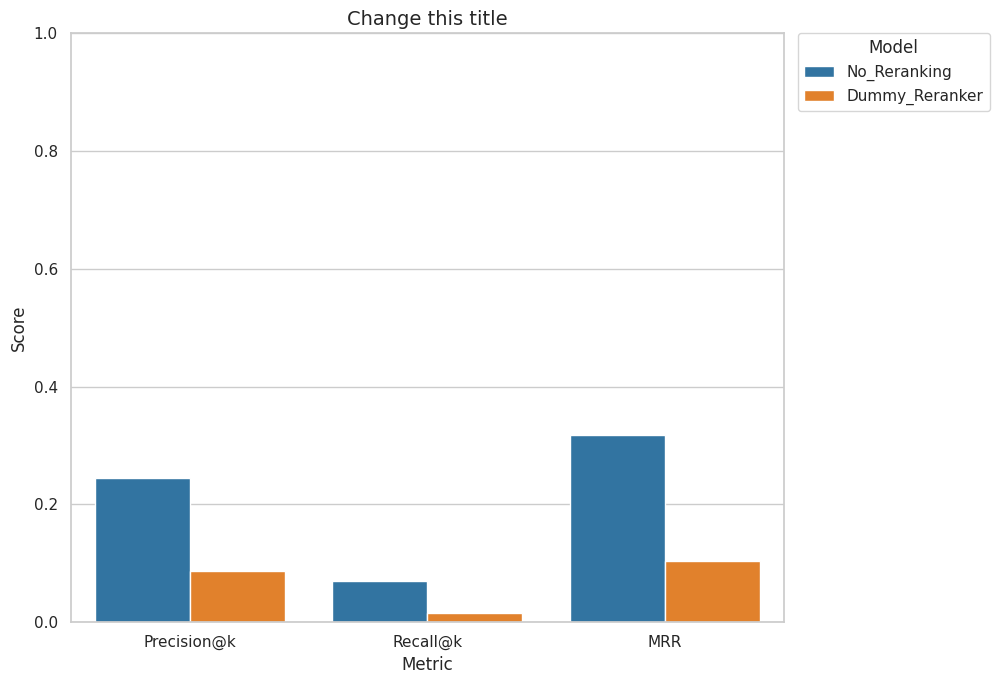

In [58]:
plot_evaluation_results_extended(final_set_evaluation_results, title="Change this title")

## 1.1 Setup of the environment

### Setting seeds and mounting Google Drive storage folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_folder = '/content/drive/MyDrive/AdvGenAI'

In [ ]:
import pickle
import os
import re
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import seaborn as sns
import tempfile

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.7.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.7
ale-py                                0.11.0
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.9.0
argon2-cffi                           23.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.2
arviz                                 0.21.0
astropy                               7.1.0
astropy-iers-data                     0.2025.5.19.0.38.36
astunparse                            1

In [ ]:
# Set the seed for consistent results
seed_value = 2138247234
random.seed(seed_value)
np.random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

In [ ]:
# Load Q_A_data file
with open(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-08-q-a-file-with-relevancy.pkl'), 'rb') as f:
    Q_A_ground_thruth_relevancy_dict = pickle.load(f)

In [ ]:
QQ = pd.DataFrame.from_dict(Q_A_ground_thruth_relevancy_dict, orient='index')
QQ.head()

,question,answer,possible_relevant_chunks,ground_truth_relevance,evaluation_comments
1,Who was president of ETH in 2003?,Olaf Kübler,"{3016_02, 2929_06, 2993_04, 3034_03, 4166_23, ...","{'3318_03': 0.0, '2550_02': 0.0, '3408_02': 0....",
2,Who were the rectors of ETH between 2017 and 2...,"Sarah Springman, Günther Dissertori","{3293_02, 2308_09, 3138_01, 2806_02, 3253_03, ...","{'3234_12': 0.0, '3318_03': 0.0, '0013_13': 0....",
3,Who at ETH received ERC grants?,European Research Council grants: Tobias Donne...,"{3021_07, 1186_00, 0909_01, 3985_06, 3415_08, ...","{'2478_00': 0.0, '3788_00': 0.0, '3899_03': 0....",The criterion here: does it come up with a lis...
4,When did the InSight get to Mars?,26 November 2018,"{4180_00, 0932_00, 3838_07, 1087_02, 2855_01, ...","{'1098_04': 0.0, '0188_03': 0.0, '3592_05': 0....",
5,What did Prof. Schubert say about ﬂying?,Flying is too cheap. If we want to reduce ﬂyin...,"{2343_00, 4193_04, 3986_11, 3395_06, 0180_02, ...","{'1376_09': 0.0, '2888_02': 0.0, '3999_05': 0....",


In [ ]:
print(QQ.columns)

Index(['question', 'answer', 'possible_relevant_chunks',
       'ground_truth_relevance', 'evaluation_comments'],
      dtype='object')


In [ ]:
df_chun = pd.read_csv(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-02-chunked-dataset.csv'))

In [ ]:
df_chun.head()

,unique_chunk_id,chunk_text,chunk_length,total_chunks,folder_path,file_name,year,month,language,type,title,text_id,chunk_id
0,0000_00,"Als 1950 die Meteorologen Jule Charney, Ragnar...",563,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0,0
1,0000_01,## Erstaunliche Entwicklung der Klimamodelle\n...,804,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0,1
2,0000_02,"«Alle Modelle sind falsch, aber einige sind nü...",881,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0,2
3,0000_03,"Doch um die Gitterweite verkleinern zu können,...",536,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0,3
4,0000_04,Bis ein hochaufgelöstes Modell auf einer neuen...,466,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0,4


In [ ]:
print(df_chun.columns)

Index(['unique_chunk_id', 'chunk_text', 'chunk_length', 'total_chunks',
       'folder_path', 'file_name', 'year', 'month', 'language', 'type',
       'title', 'text_id', 'chunk_id'],
      dtype='object')


In [ ]:
type(QQ['possible_relevant_chunks'].head()[1])

set

In [ ]:
list(QQ['possible_relevant_chunks'][2])[0]

'3293_02'

In [ ]:
from nltk.tokenize import sent_tokenize

def get_chunk_sentences(chunk_ids, df_chunks):
    sentences = []
    for cid in chunk_ids:
        if cid in df_chunks.index:
            chunk_text = df_chunks.loc[cid]['chunk_text']
            sentences.extend(sent_tokenize(chunk_text))
    return sentences


In [ ]:
from sentence_transformers import SentenceTransformer, util
import torch

model = SentenceTransformer("all-MiniLM-L6-v2")

def score_sentences(query, sentences):
    query_emb = model.encode(query, convert_to_tensor=True)
    sent_embs = model.encode(sentences, convert_to_tensor=True)
    scores = util.cos_sim(query_emb, sent_embs)[0].cpu().numpy()
    return scores


In [ ]:
def dslr_refine(query, chunk_ids, df_chunks, top_k=5):
    sentences = get_chunk_sentences(chunk_ids, df_chunks)
    if not sentences:
        return ""  # fallback for empty input
    scores = score_sentences(query, sentences)
    top_idx = scores.argsort()[-top_k:][::-1]
    top_sentences = [sentences[i] for i in top_idx]
    return " ".join(top_sentences)


In [ ]:
df_main["refined_context"] = df_main.apply(
    lambda row: dslr_refine(row["question"], row["possible_relevant_chunks"], df_chun),
    axis=1
)


there is a new column refined_context, where each row contains a query-focused, sentence-level refined passage assembled from the top relevant chunks.